In [3]:
from nilearn import datasets, input_data, plotting, image
from nilearn.plotting import plot_prob_atlas, plot_stat_map, show
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import iter_img
import nibabel as nib
from nilearn.connectome import ConnectivityMeasure, GroupSparseCovarianceCV
from nilearn.decomposition import CanICA, DictLearning
from nilearn.regions import RegionExtractor, Parcellations
import numpy as np
from sklearn.covariance import GraphLassoCV
from sklearn.externals.joblib import Memory
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import LinearSVC
mem = Memory('nilearn_cache')
import matplotlib.pylab as plt

%matplotlib inline

# 3.1. Extracting times series to build a functional connectome
## 3.1.1. Time-series from a brain parcellation or “MaxProb” atlas

In [2]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

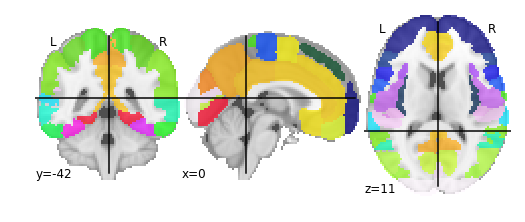

In [3]:
plotting.plot_roi(atlas_filename)

In [4]:
atlas_filename

'/home/users/zenkavi/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz'

In [5]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' %
      atlas_filename)  # 4D data

# One subject of resting-state data
data = datasets.fetch_adhd(n_subjects=1)
fmri_filenames = data.func[0]

Atlas ROIs are located in nifti image (4D) at: /home/users/zenkavi/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz


In [6]:
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
time_series = masker.fit_transform(fmri_filenames, confounds=data.confounds)

[NiftiLabelsMasker.fit_transform] loading data from /home/users/zenkavi/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
[Memory]    0.0s, 0.0min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [7]:
nib.load(fmri_filenames).get_fdata().shape

(61, 73, 61, 176)

In [8]:
time_series.shape

(176, 48)

In [9]:
len(labels)

49

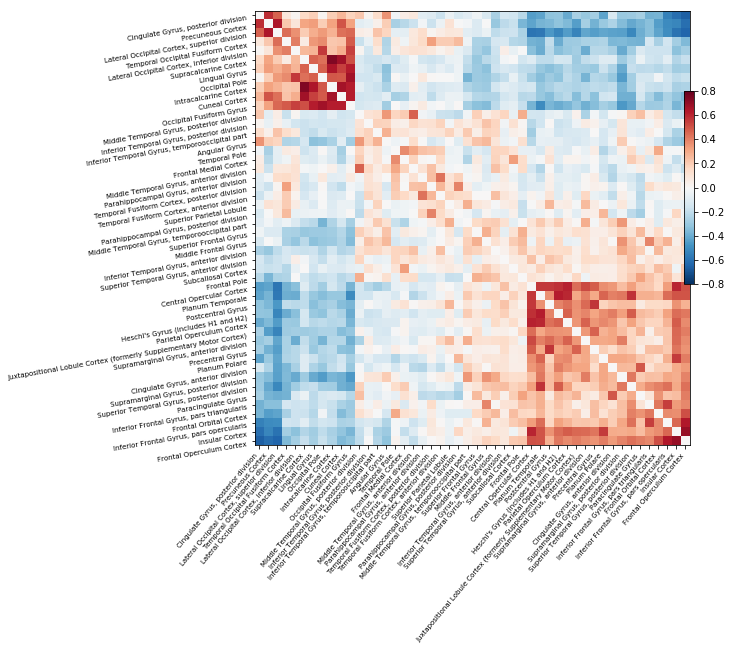

In [10]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

## 3.1.2. Time-series from a probabilistic atlas

In [11]:
atlas_data = datasets.fetch_atlas_msdl()
atlas_filename = atlas_data.maps


Dataset created in /home/users/zenkavi/nilearn_data/msdl_atlas



Downloaded 209734 of 209734 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/msdl_atlas/5d25e157f36214b8ca9a12fd417aac1c/MSDL_rois.zip..... done.


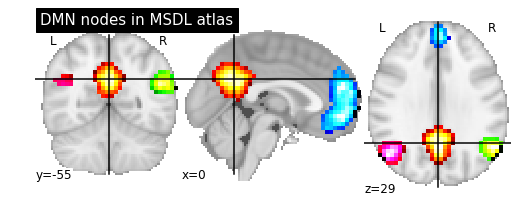

In [14]:
display = plotting.plot_stat_map(image.index_img(atlas_filename, 4),
                                 colorbar=False,
                                 title="DMN nodes in MSDL atlas")

# Now add as an overlay the maps for the ACC and the left and right
# parietal nodes
display.add_overlay(image.index_img(atlas_filename, 5),
                    cmap=plotting.cm.black_blue)
display.add_overlay(image.index_img(atlas_filename, 6),
                    cmap=plotting.cm.black_green)
display.add_overlay(image.index_img(atlas_filename, 3),
                    cmap=plotting.cm.black_pink)

plotting.show()

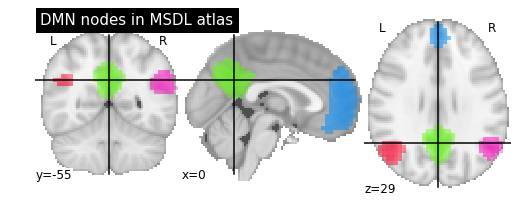

In [15]:
dmn_nodes = image.index_img(atlas_filename, [3, 4, 5, 6])
# Note that dmn_node is now a 4D image
#print(dmn_nodes.shape)
display = plotting.plot_prob_atlas(dmn_nodes,
                                   cut_coords=(0, -55, 29),
                                   title="DMN nodes in MSDL atlas")
plotting.show()

In [17]:
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
labels = atlas['labels']

# Load the functional datasets
data = datasets.fetch_adhd(n_subjects=1)

print('First subject resting-state nifti image (4D) is located at: %s' %
      data.func[0])

First subject resting-state nifti image (4D) is located at: /home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


In [18]:
from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                         memory='nilearn_cache', verbose=5)

time_series = masker.fit_transform(data.func[0],
                                   confounds=data.confounds)

[NiftiMapsMasker.fit_transform] loading regions from /home/users/zenkavi/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x7f533c38def0>, target_shape=(61, 73, 61), interpolation='continuous', target_affine=array([[  -3.,   -0.,   -0.,   90.],
       [  -0.,    3.,   -0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]]))
_____________________________________________________resample_img - 3.0s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_

In [19]:
print(time_series.shape)

(176, 39)


In [21]:
len(labels)

39

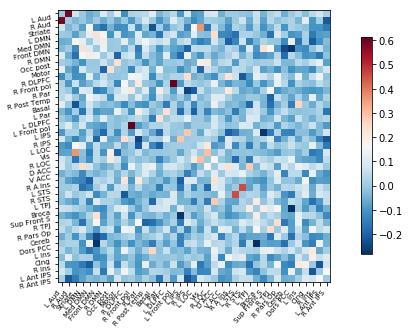

In [29]:
correlation_measure = ConnectivityMeasure(kind='partial correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True)


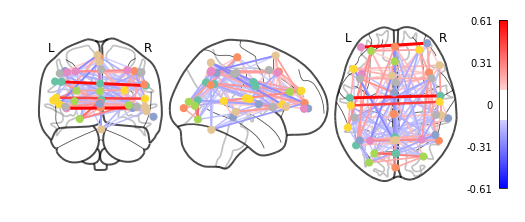

In [30]:
from nilearn import plotting
coords = atlas.region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

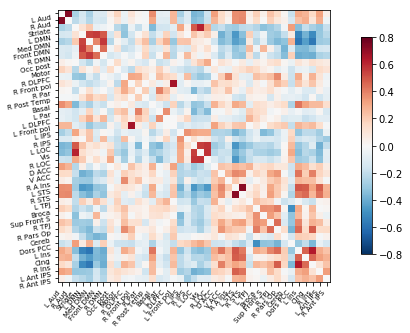

In [27]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True,
                     vmax=0.8, vmin=-0.8)


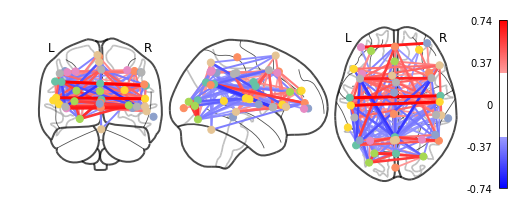

In [28]:
coords = atlas.region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

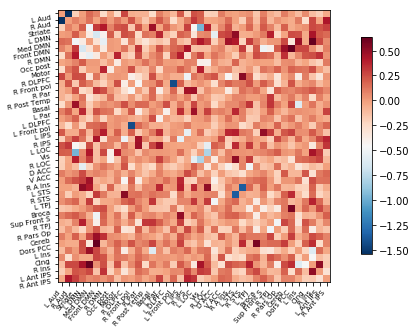

In [32]:
correlation_measure = ConnectivityMeasure(kind='precision')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True)


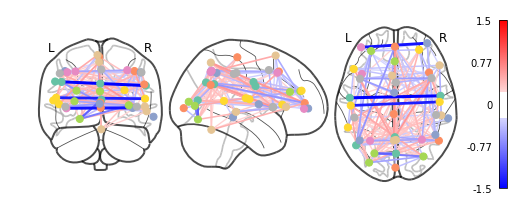

In [33]:
coords = atlas.region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

# 3.2. Connectome extraction: inverse covariance for direct connections 

## 3.2.1. Sparse inverse covariance for functional connectomes

In [34]:
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
labels = atlas['labels']

# Loading the functional datasets
data = datasets.fetch_adhd(n_subjects=1)

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      data.func[0])  # 4D data

First subject functional nifti images (4D) are at: /home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


In [35]:
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                         memory='nilearn_cache', verbose=5)

time_series = masker.fit_transform(data.func[0],
                                   confounds=data.confounds)

[NiftiMapsMasker.fit_transform] loading regions from /home/users/zenkavi/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
[Memory]    0.0s, 0.0min: Loading resample_img...
________________________________________resample_img cache loaded - 0.2s, 0.0min
[Memory]    0.5s, 0.0min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [37]:
estimator = GraphLassoCV()

estimator.fit(time_series)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

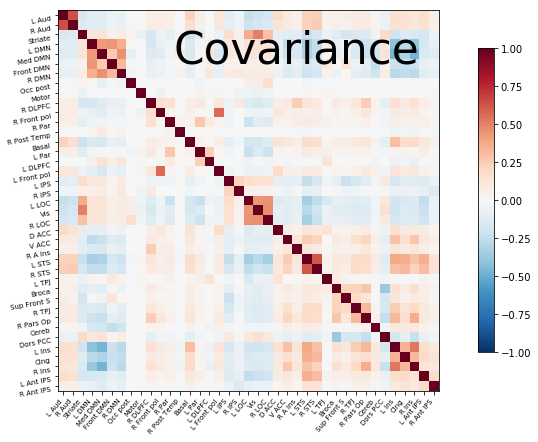

In [38]:
plotting.plot_matrix(estimator.covariance_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Covariance')

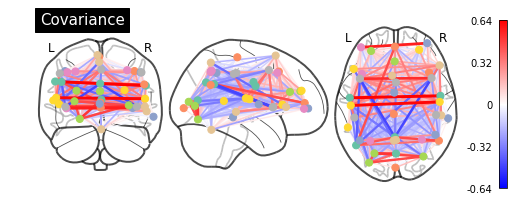

In [40]:
coords = atlas.region_coords

plotting.plot_connectome(estimator.covariance_, coords,
                         title='Covariance',colorbar=True)

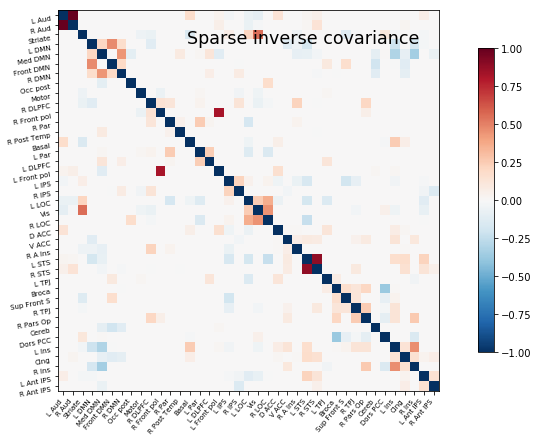

In [41]:
#NOTE THE NEGATION OF THE PRECISION ESTIMATE!
plotting.plot_matrix(-estimator.precision_, labels=labels,
                     figure=(9, 7), vmax=1, vmin=-1,
                     title='Sparse inverse covariance')

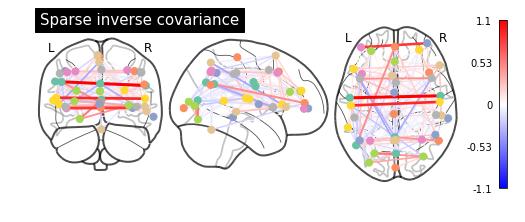

In [43]:
#NOTE THE NEGATION OF THE PRECISION ESTIMATE!
plotting.plot_connectome(-estimator.precision_, coords,
                         title='Sparse inverse covariance', colorbar=True)

plotting.show()

## 3.2.2. Sparse inverse covariance on multiple subjects

In [44]:
n_subjects = 4  # subjects to consider for group-sparse covariance (max: 40)


def plot_matrices(cov, prec, title, labels):
    """Plot covariance and precision matrices, for a given processing. """

    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    # Display covariance matrix
    plotting.plot_matrix(cov, cmap=plotting.cm.bwr,
                         vmin=-1, vmax=1, title="%s / covariance" % title,
                         labels=labels)
    # Display precision matrix
    plotting.plot_matrix(prec, cmap=plotting.cm.bwr,
                         vmin=-span, vmax=span, title="%s / precision" % title,
                         labels=labels)

In [45]:
msdl_atlas_dataset = datasets.fetch_atlas_msdl()
adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)

Downloaded 45583539 of 45583539 bytes (100.0%,    0.0s remaining) ...done. (4 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/fcb8ffb308250f45e3e01bfcf5f71890/adhd40_0010064.tgz..... done.


Downloaded 45461055 of 45461055 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/fcb8ffb308250f45e3e01bfcf5f71890/adhd40_0010128.tgz..... done.


Downloaded 46216320 of 46216320 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/fcb8ffb308250f45e3e01bfcf5f71890/adhd40_0021019.tgz..... done.


In [49]:
masker = input_data.NiftiMapsMasker(
    msdl_atlas_dataset.maps, resampling_target="maps", detrend=True,
    low_pass=None, high_pass=0.01, t_r=2.5, standardize=True,
    memory='nilearn_cache', memory_level=1, verbose=2)
masker.fit()

subject_time_series = []
func_filenames = adhd_dataset.func
confound_filenames = adhd_dataset.confounds
for func_filename, confound_filename in zip(func_filenames,
                                            confound_filenames):
    print("Processing file %s" % func_filename)

    # Computing some confounds
    hv_confounds = mem.cache(image.high_variance_confounds)(
        func_filename)

    region_ts = masker.transform(func_filename,
                                 confounds=[hv_confounds, confound_filename])
    subject_time_series.append(region_ts)

[NiftiMapsMasker.fit] loading regions from /home/users/zenkavi/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Processing file /home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.image.image.high_variance_confounds...
high_variance_confounds('/home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
__________________________________________high_variance_confounds - 2.5s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', 
{ 'allow_overlap': True,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.01,
  'low_pass': None,
  'maps_img': '/home/users/zenkavi/nilearn_data/msdl_atlas/MSDL_rois

In [55]:
# List of 4 subjects' time series
len(subject_time_series)

4

In [56]:
# 176 TRs for 39 nodes
subject_time_series[0].shape

(176, 39)

In [59]:
from nilearn.connectome import GroupSparseCovarianceCV
gsc = GroupSparseCovarianceCV(verbose=2)
gsc.fit(subject_time_series)

gl = GraphLassoCV(verbose=2)
gl.fit(np.concatenate(subject_time_series))

[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 5
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  1 out of 4


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s finished


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 5
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 7
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  2 out of 4


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s finished


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 5
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  3 out of 4


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.0s finished


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 9
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  4 out of 4
[GroupSparseCovarianceCV.fit] Final optimization


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.4s finished


[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 15: 7.267e-04


....[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
....[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[GraphLassoCV] Done refinement  1 out of 4:   0s


........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


[GraphLassoCV] Done refinement  2 out of 4:   0s


....[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
........[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
..

[GraphLassoCV] Done refinement  3 out of 4:   0s


..[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
......

[GraphLassoCV] Done refinement  4 out of 4:   1s
[graph_lasso] Iteration   0, cost  1.71e+02, dual gap 7.592e-01
[graph_lasso] Iteration   1, cost  1.71e+02, dual gap 6.267e-03
[graph_lasso] Iteration   2, cost  1.71e+02, dual gap 2.011e-04
[graph_lasso] Iteration   3, cost  1.71e+02, dual gap 1.307e-04
[graph_lasso] Iteration   4, cost  1.71e+02, dual gap -2.875e-05


..[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=2)

In [61]:
# GraphLassoCV treats all data as coming from one subject
np.concatenate(subject_time_series).shape

(703, 39)

In [64]:
# Group sparse lasso estimates a connectivity matrix for each subject separately
gsc.precisions_.shape

(39, 39, 4)

In [66]:
# Graph lasso estimates one for all subjects
gl.precision_.shape

(39, 39)

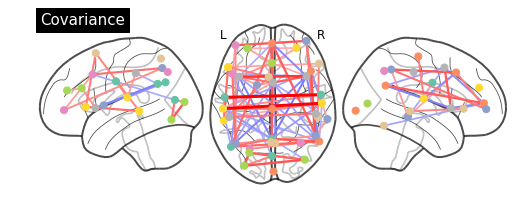

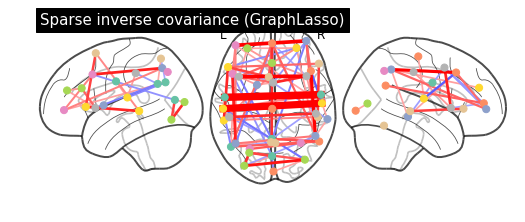

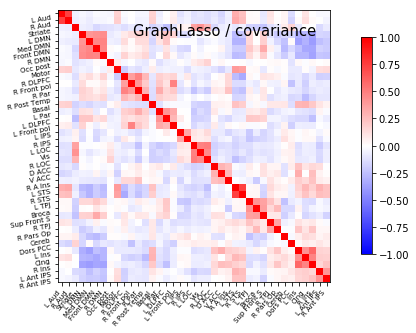

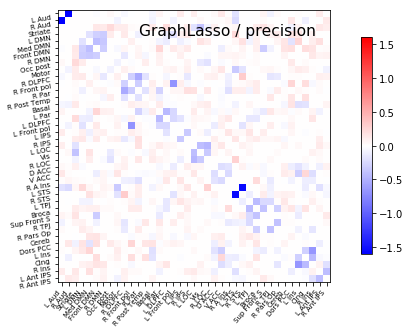

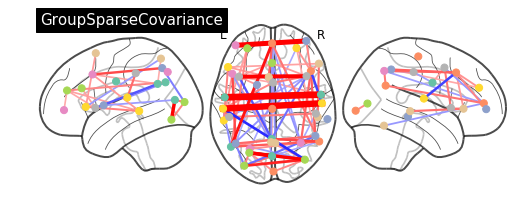

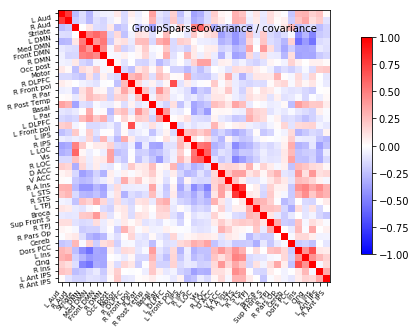

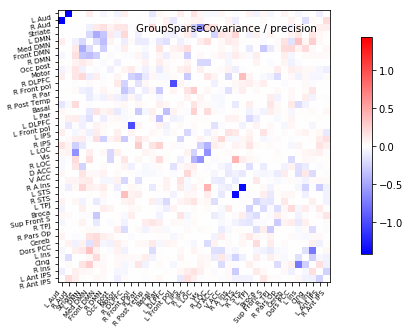

In [67]:
atlas_img = msdl_atlas_dataset.maps
atlas_region_coords = plotting.find_probabilistic_atlas_cut_coords(atlas_img)
labels = msdl_atlas_dataset.labels

plotting.plot_connectome(gl.covariance_,
                         atlas_region_coords, edge_threshold='90%',
                         title="Covariance",
                         display_mode="lzr")
plotting.plot_connectome(-gl.precision_, atlas_region_coords,
                         edge_threshold='90%',
                         title="Sparse inverse covariance (GraphLasso)",
                         display_mode="lzr",
                         edge_vmax=.5, edge_vmin=-.5)
plot_matrices(gl.covariance_, gl.precision_, "GraphLasso", labels)

title = "GroupSparseCovariance"
plotting.plot_connectome(-gsc.precisions_[..., 0],
                         atlas_region_coords, edge_threshold='90%',
                         title=title,
                         display_mode="lzr",
                         edge_vmax=.5, edge_vmin=-.5)
plot_matrices(gsc.covariances_[..., 0],
              gsc.precisions_[..., 0], title, labels)

plotting.show()

## 3.2.4. Linking total and direct interactions at the group level

In [69]:
def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

In [70]:
adhd_data = datasets.fetch_adhd(n_subjects=20)

Downloaded 20407901 of 20407901 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_0023008.tgz..... done.


Downloaded 20706939 of 20706939 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_0023012.tgz..... done.


Downloaded 72402326 of 72402326 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_0027011.tgz..... done.


Downloaded 76184603 of 76184603 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_0027018.tgz..... done.


Downloaded 70074120 of 70074120 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_0027034.tgz..... done.


Downloaded 69291635 of 69291635 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_0027037.tgz..... done.


Downloaded 41803342 of 41803342 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_1019436.tgz..... done.


Downloaded 20763649 of 20763649 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_1206380.tgz..... done.


Downloaded 20168043 of 20168043 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_1418396.tgz..... done.


Downloaded 62682233 of 62682233 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_1517058.tgz..... done.


Downloaded 20196558 of 20196558 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_1552181.tgz..... done.


Downloaded 60663491 of 60663491 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_1562298.tgz..... done.


Downloaded 20628764 of 20628764 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_1679142.tgz..... done.


Downloaded 33119052 of 33119052 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_2014113.tgz..... done.


Downloaded 45455025 of 45455025 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_2497695.tgz..... done.


Downloaded 57992968 of 57992968 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/51ca93ac61e627213eb5a3bb40abfcc0/adhd40_2950754.tgz..... done.


In [71]:
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))

MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


In [72]:
masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2.5, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)

In [73]:
adhd_subjects = []
pooled_subjects = []
site_names = []
adhd_labels = []  # 1 if ADHD, 0 if control
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd:
        adhd_subjects.append(time_series)

    site_names.append(phenotypic['site'])
    adhd_labels.append(is_adhd)

print('Data has {0} ADHD subjects.'.format(len(adhd_subjects)))

Data has 13 ADHD subjects.


In [80]:
sum(adhd_data.phenotypic['adhd'])

13

In [81]:
correlation_measure = ConnectivityMeasure(kind='correlation')

In [82]:
correlation_matrices = correlation_measure.fit_transform(adhd_subjects)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of ADHD patients are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))

Correlations of ADHD patients are stacked in an array of shape (13, 39, 39)


In [83]:
mean_correlation_matrix = correlation_measure.mean_
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Mean correlation has shape (39, 39).


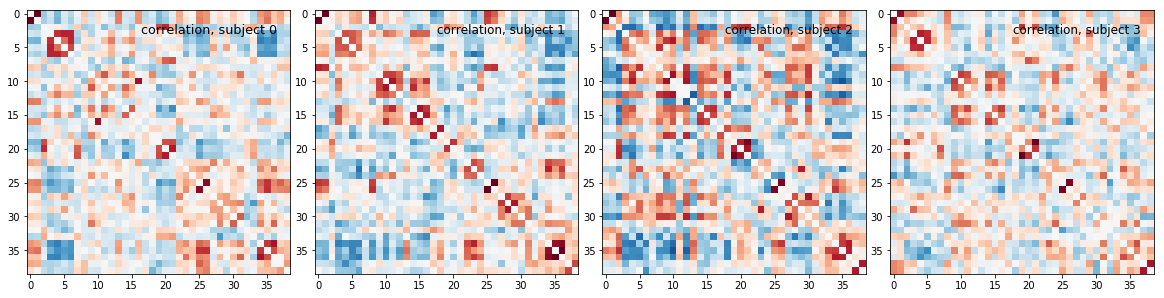

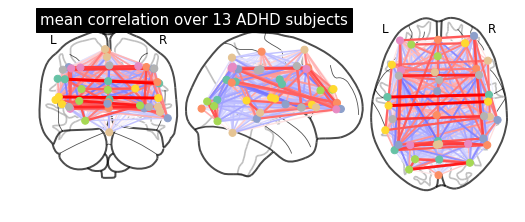

In [84]:
plot_matrices(correlation_matrices[:4], 'correlation')
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         title='mean correlation over 13 ADHD subjects')

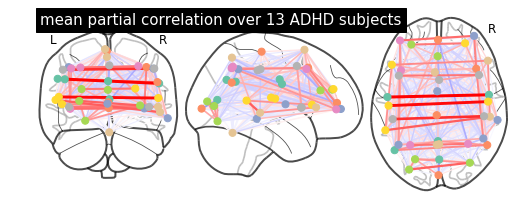

In [85]:
partial_correlation_measure = ConnectivityMeasure(kind='partial correlation')
partial_correlation_matrices = partial_correlation_measure.fit_transform(
    adhd_subjects)
plotting.plot_connectome(
    partial_correlation_measure.mean_, msdl_coords,
    title='mean partial correlation over 13 ADHD subjects')

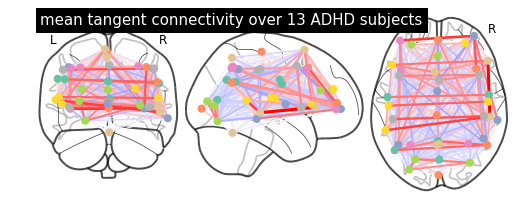

In [86]:
tangent_measure = ConnectivityMeasure(kind='tangent')

tangent_matrices = tangent_measure.fit_transform(adhd_subjects)

plotting.plot_connectome(
    tangent_measure.mean_, msdl_coords,
    title='mean tangent connectivity over 13 ADHD subjects')

In [88]:
len(pooled_subjects)

20

In [90]:
pooled_subjects[0].shape

(176, 39)

In [91]:
connectivity_biomarkers = {}
kinds = ['correlation', 'partial correlation', 'tangent']
for kind in kinds:
    conn_measure = ConnectivityMeasure(kind=kind, vectorize=True)
    connectivity_biomarkers[kind] = conn_measure.fit_transform(pooled_subjects)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers['correlation'].shape[1]))

780 correlation biomarkers for each subject.


In [99]:
classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(site_names, adhd_labels)]
cv = StratifiedKFold(n_splits=3)

In [102]:
mean_scores = []
for kind in kinds:
    svc = LinearSVC(random_state=0)
    cv_scores = cross_val_score(svc,
                                connectivity_biomarkers[kind],
                                y=adhd_labels,
                                cv=cv,
                                groups=adhd_labels,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())

In [103]:
mean_scores

[0.5972222222222222, 0.5972222222222222, 0.6944444444444445]

In [107]:
connectivity_biomarkers['correlation'].shape

(20, 780)

In [109]:
cv_scores

array([0.75      , 0.83333333, 0.5       ])

What did this do? 

Estimate the connectivity matrix for each of 20 subjects using different metrics  
The the nodes of the connectivity matrix is based on the probabilistic MDSL atlas. We haven't done any node determination based on our group and then re-applied that to each subject in the sample at this point.  
Stacked and stored the 20 matrices for each metric in a single array  
Used the connectivity vector to predict the clinical label for each of the 3 metrics  
Prediction used CV with stratified folds for prediction  
Mean scores contains the mean cross validation score for each of the 3 folds for each of the 3 metrics  

# 3.3. Extracting resting-state networks: ICA and related 

## 3.3.1. Multi-subject ICA: CanICA

In [110]:
adhd_dataset = datasets.fetch_adhd(n_subjects=30)
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

Downloaded 67925261 of 67925261 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/083500922dc983e37a43eed2bafac795/adhd40_3007585.tgz..... done.


Downloaded 32919780 of 32919780 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/083500922dc983e37a43eed2bafac795/adhd40_3154996.tgz..... done.


Downloaded 59835286 of 59835286 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/083500922dc983e37a43eed2bafac795/adhd40_3205761.tgz..... done.


Downloaded 61857076 of 61857076 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/083500922dc983e37a43eed2bafac795/adhd40_3520880.tgz..... done.


Downloaded 59385206 of 59385206 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/083500922dc983e37a43eed2bafac795/adhd40_3624598.tgz..... done.


Downloaded 41518251 of 41518251 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/083500922dc983e37a43eed2bafac795/adhd40_3699991.tgz..... done.


Downloaded 32108848 of 32108848 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/083500922dc983e37a43eed2bafac795/adhd40_3884955.tgz..... done.


Downloaded 39415752 of 39415752 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/083500922dc983e37a43eed2bafac795/adhd40_3902469.tgz..... done.


Downloaded 59297020 of 59297020 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/083500922dc983e37a43eed2bafac795/adhd40_3994098.tgz..... done.


Downloaded 20157314 of 20157314 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/users/zenkavi/nilearn_data/adhd/083500922dc983e37a43eed2bafac795/adhd40_4016887.tgz..... done.


In [112]:
canica = CanICA(n_components=20, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
canica.fit(func_filenames)

# Retrieve the independent components in brain space. Directly
# accesible through attribute `components_img_`. Note that this
# attribute is implemented from version 0.4.1. For older versions,
# see note section above for details.
components_img = canica.components_img_

[MultiNiftiMasker.fit] Loading data from [/home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz, /home/users/zenkavi/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz, /home/users/z
[MultiNiftiMasker.fit] Computing mask


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   51.6s finished


[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/users/zenkavi/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/users/zenkavi/nilearn_data/adhd/data/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothin

[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/users/zenkavi/nilearn_data/adhd/data/3520880/3520880_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/users/zenkavi/nilearn_data/adhd/data/3624598/3624598_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/users/zenkavi/nilearn_data/adhd/data/3699991/3699991_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothi

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


__________________________________________________________fastica - 1.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.002964, ...,  0.004765],
       ...,
       [ 0.003539, ..., -0.004918]]), fun='cube', whiten=True, random_state=924231285)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


__________________________________________________________fastica - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.002964, ...,  0.004765],
       ...,
       [ 0.003539, ..., -0.004918]]), fun='cube', whiten=True, random_state=1478610112)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s


__________________________________________________________fastica - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.002964, ...,  0.004765],
       ...,
       [ 0.003539, ..., -0.004918]]), fun='cube', whiten=True, random_state=441365315)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.1s remaining:    0.0s


__________________________________________________________fastica - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.002964, ...,  0.004765],
       ...,
       [ 0.003539, ..., -0.004918]]), fun='cube', whiten=True, random_state=1537364731)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.4s remaining:    0.0s


__________________________________________________________fastica - 2.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.002964, ...,  0.004765],
       ...,
       [ 0.003539, ..., -0.004918]]), fun='cube', whiten=True, random_state=192771779)


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   14.3s remaining:    0.0s


__________________________________________________________fastica - 4.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.002964, ...,  0.004765],
       ...,
       [ 0.003539, ..., -0.004918]]), fun='cube', whiten=True, random_state=1491434855)


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   18.5s remaining:    0.0s


__________________________________________________________fastica - 4.3s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.002964, ...,  0.004765],
       ...,
       [ 0.003539, ..., -0.004918]]), fun='cube', whiten=True, random_state=1819583497)


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   22.9s remaining:    0.0s


__________________________________________________________fastica - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.fastica_.fastica...
fastica(array([[ 0.002964, ...,  0.004765],
       ...,
       [ 0.003539, ..., -0.004918]]), fun='cube', whiten=True, random_state=530702035)


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   25.7s remaining:    0.0s


__________________________________________________________fastica - 2.6s, 0.0min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.4s finished


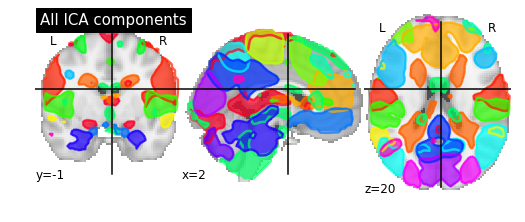

In [114]:
plot_prob_atlas(components_img, title='All ICA components')

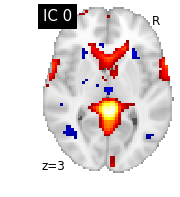

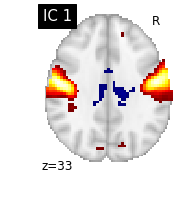

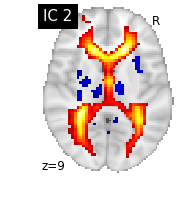

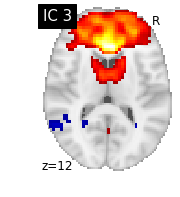

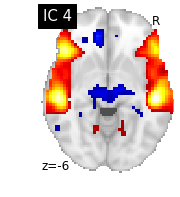

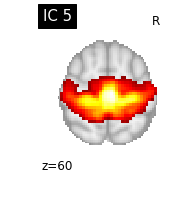

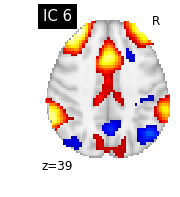

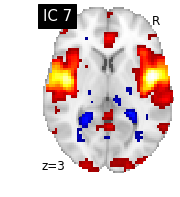

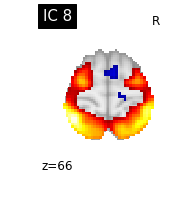

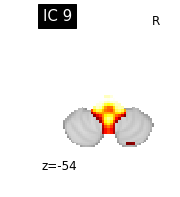

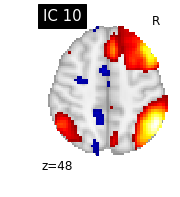

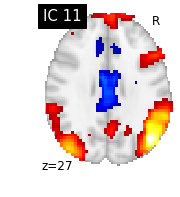

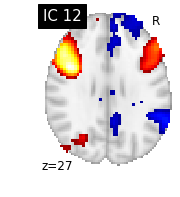

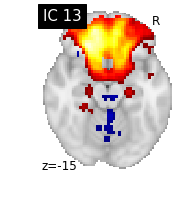

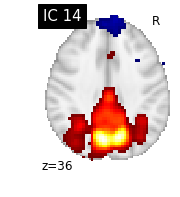

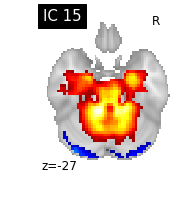

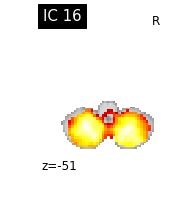

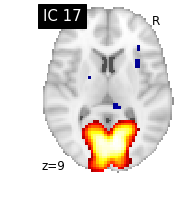

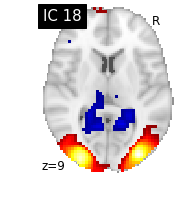

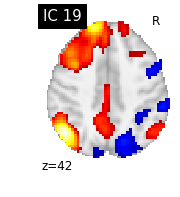

In [116]:
for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)

# 3.4. Region Extraction for better brain parcellations

In [117]:
adhd_dataset = datasets.fetch_adhd(n_subjects=20)
func_filenames = adhd_dataset.func
confounds = adhd_dataset.confounds

## 3.4.2. Brain maps using Dictionary Learning¶

In [119]:
dict_learn = DictLearning(n_components=5, smoothing_fwhm=6.,
                          memory="nilearn_cache", memory_level=2,
                          random_state=0)
# Fit to the data
dict_learn.fit(func_filenames)
# Resting state networks/maps in attribute `components_img_`
# Note that this attribute is implemented from version 0.4.1.
# For older versions, see the note section above for details.
components_img = dict_learn.components_img_

## 3.4.4. Region Extraction with Dictionary Learning maps

In [122]:
extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=1350)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]


/home/groups/russpold/software/miniconda/envs/fmri/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


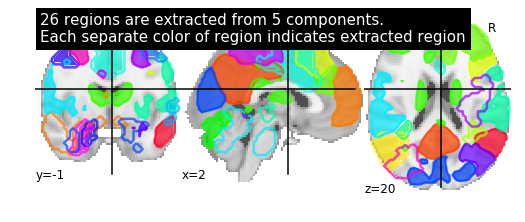

In [123]:
title = ('%d regions are extracted from %d components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 5))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)


## 3.4.6. Computing functional connectivity matrices

In [137]:
correlations = []
# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
for filename, confound in zip(func_filenames, confounds):
    # call transform from RegionExtractor object to extract timeseries signals
    timeseries_each_subject = extractor.transform(filename, confounds=confound)
    # call fit_transform from ConnectivityMeasure object
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    # saving each subject correlation to correlations
    correlations.append(correlation)

# Mean of all correlations
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted,
                                                          n_regions_extracted)

In [143]:
timeseries_each_subject.shape

(236, 26)

In [144]:
mean_correlations.shape

(26, 26)

In [147]:
len(correlations)

20

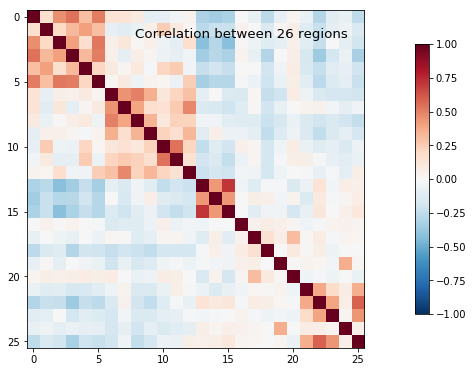

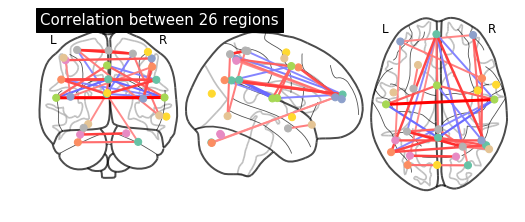

In [149]:
title = 'Correlation between %d regions' % n_regions_extracted

# First plot the matrix
display = plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1,
                               colorbar=True, title=title)

# Then find the center of the regions and plot a connectome
regions_img = regions_extracted_img
coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

plotting.plot_connectome(mean_correlations, coords_connectome,
                         edge_threshold='90%', title=title)


## 3.4.8. Validating results¶

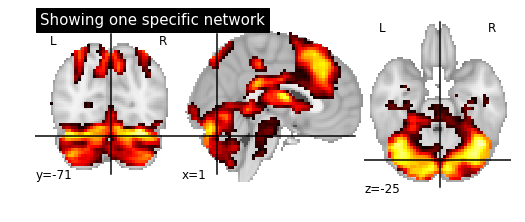

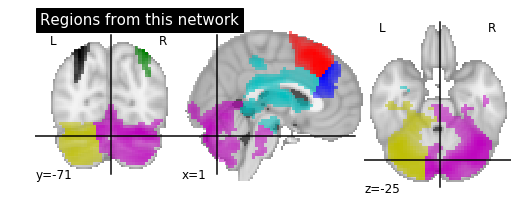

In [151]:
img = image.index_img(components_img, 1)
coords = plotting.find_xyz_cut_coords(img)
display = plotting.plot_stat_map(img, cut_coords=coords, colorbar=False,
                                 title='Showing one specific network')

################################################################################
# Now, we plot (right side) same network after region extraction to show that
# connected regions are nicely seperated.
# Each brain extracted region is identified as separate color.

# For this, we take the indices of the all regions extracted related to original
# network given as 4.
regions_indices_of_map3 = np.where(np.array(regions_index) == 1)

display = plotting.plot_anat(cut_coords=coords,
                             title='Regions from this network')

# Add as an overlay all the regions of index 4
colors = 'rgbcmyk'
for each_index_of_map3, color in zip(regions_indices_of_map3[0], colors):
    display.add_overlay(image.index_img(regions_extracted_img, each_index_of_map3),
                        cmap=plotting.cm.alpha_cmap(color))

plotting.show()

# 3.5. Clustering to parcellate the brain in regions¶

In [5]:
from nilearn import datasets
dataset = datasets.fetch_adhd(n_subjects=1)

# print basic information on the dataset
print('First subject functional nifti image (4D) is at: %s' %
      dataset.func[0])  # 4D data

First subject functional nifti image (4D) is at: /home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


In [6]:
# Computing ward for the first time, will be long... This can be seen by
# measuring using time
import time
start = time.time()

# Agglomerative Clustering: ward

# We build parameters of our own for this object. Parameters related to
# masking, caching and defining number of clusters and specific parcellations
# method.
ward = Parcellations(method='ward', n_parcels=1000,
                     standardize=False, smoothing_fwhm=2.,
                     memory='nilearn_cache', memory_level=1,
                     verbose=1)
# Call fit on functional dataset: single subject (less samples).
ward.fit(dataset.func)
print("Ward agglomeration 1000 clusters: %.2fs" % (time.time() - start))

# We compute now ward clustering with 2000 clusters and compare
# time with 1000 clusters. To see the benefits of caching for second time.

# We initialize class again with n_parcels=2000 this time.
start = time.time()
ward = Parcellations(method='ward', n_parcels=2000,
                     standardize=False, smoothing_fwhm=2.,
                     memory='nilearn_cache', memory_level=1,
                     verbose=1)
ward.fit(dataset.func)
print("Ward agglomeration 2000 clusters: %.2fs" % (time.time() - start))

[MultiNiftiMasker.fit] Loading data from [/home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz]
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[Parcellations] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/users/zenkavi/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[Parcellations] computing ward
________________________________________________________________________________
[Memory] Calling nilearn.regions.parcellations._estimator_fit...
_estimator_fit(array([[-0.004366, ...,  0.000667],
       ...,
       [-0.007785, ...,  0.001398]], dtype=float32), 
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<62